In [1]:
import pandas as pd

In [3]:
df = pd.read_parquet('/workspaces/MLOps_zoomcamp_2024/data/yellow_tripdata_2023-01.parquet')
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.30,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.90,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.90,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.10,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.40,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,NaN,3.05,NaN,None,107,48,0,15.80,0.00,0.5,3.96,0.0,1.0,23.76,NaN,NaN
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,NaN,5.80,NaN,None,112,75,0,22.43,0.00,0.5,2.64,0.0,1.0,29.07,NaN,NaN
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,NaN,4.67,NaN,None,114,239,0,17.61,0.00,0.5,5.32,0.0,1.0,26.93,NaN,NaN
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,NaN,3.15,NaN,None,230,79,0,18.15,0.00,0.5,4.43,0.0,1.0,26.58,NaN,NaN


In [4]:
# creating the duration variable
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df.duration.describe()

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
25%      7.116667e+00
50%      1.151667e+01
75%      1.830000e+01
max      1.002918e+04
Name: duration, dtype: float64

In [5]:
# Dropping outliers

original_length = len(df)

filtered_df = df[(df.duration >= 1) & (df.duration <= 60)]  # Replace 'condition' with your filtering condition

removed_rows = original_length - len(filtered_df)

fraction_left = len(filtered_df) / original_length

# Print the results
print("Removed rows:", removed_rows)
print("Fraction of rows left:", fraction_left)

Removed rows: 57593
Fraction of rows left: 0.9812202822125979


In [10]:
from sklearn.feature_extraction import DictVectorizer

selected_columns = ['PULocationID', 'DOLocationID']
df_selected = filtered_df[selected_columns].astype(str)

dict_list = df_selected.to_dict('records')

vectorizer = DictVectorizer(sparse=True)
vectorizer.fit(dict_list)

feature_matrix = vectorizer.transform(dict_list)
feature_matrix.ndim

2

In [36]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# creating training data
numerical = ['trip_distance']

train_data =  filtered_df[selected_columns + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_data)

target = 'duration'
y_train = filtered_df[target].values

gr = GradientBoostingRegressor()
gr.fit(X_train, y_train)

y_pred = gr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


4.939734644112142

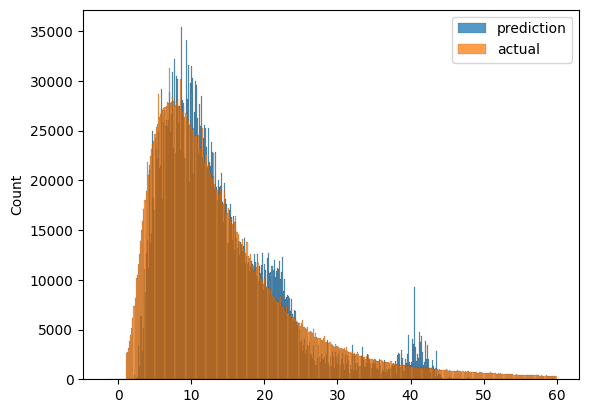

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')

plt.legend()

In [40]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.834315711621757

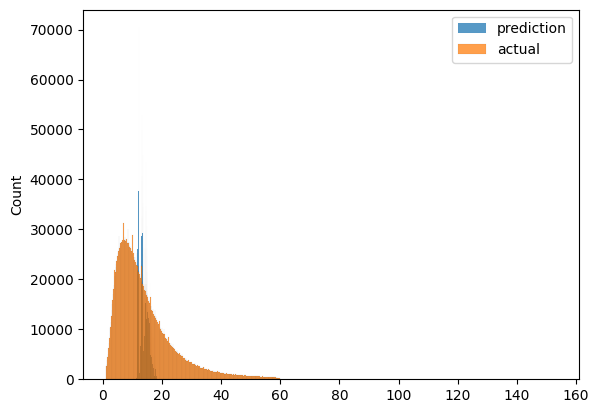

In [41]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')

plt.legend()

In [2]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
        
    return df

In [3]:
df_train = read_dataframe('/workspaces/MLOps_zoomcamp_2024/data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('/workspaces/MLOps_zoomcamp_2024/data/yellow_tripdata_2023-02.parquet')

len(df_train), len(df_val)

(3009173, 2855951)

In [7]:
from sklearn.feature_extraction import DictVectorizer

def prepare_data(df_train, df_val):
    selected_columns = ['PULocationID', 'DOLocationID']
    numerical = ['trip_distance']
    target = 'duration'

    train_data = df_train[selected_columns + numerical].to_dict(orient='records')
    y_train = df_train[target].values
    y_val = df_val[target].values

    dv = DictVectorizer(sparse=True)

    train_dicts = train_data
    X_train = dv.fit_transform(train_dicts)

    val_dicts = df_val[selected_columns + numerical].to_dict(orient='records')
    X_val = dv.transform(val_dicts)

    return X_train, X_val, y_train, y_val


In [9]:
X_train, X_val, y_train, y_val = prepare_data(df_train, df_val)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train length: {len(y_train)}")
print(f"y_val length: {len(y_val)}")

X_train shape: (3009173, 516)
X_val shape: (2855951, 516)
y_train length: 3009173
y_val length: 2855951


In [16]:
from sklearn.linear_model import  LinearRegression, Lasso
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.820139417466039

In [17]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


8.137900681701906